In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Loading and Pre-Processing

In [2]:
# loading datasets and removing last column
g_data = pd.read_csv(filepath_or_buffer='./data/G-data.csv', header=None, sep=',')
compound_data = pd.read_csv(filepath_or_buffer='./data/compound.txt', header=None, sep='\t').iloc[:,:-1]
flame_data = pd.read_csv(filepath_or_buffer='./data/flame.txt', header=None, sep='\t').iloc[:,:-1]
pathbased_data = pd.read_csv(filepath_or_buffer='./data/pathbased.txt', header=None, sep='\t').iloc[:,:-1]

datasets = {
    'G-Data': g_data,
    'Compound Data': compound_data,
    'Flame Data': flame_data,
    'Pathbased Data': pathbased_data
}

# using standard scaler to standardize each feature
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

for k in datasets.keys():
    datasets[k] = pd.DataFrame(std_scaler.fit_transform(datasets[k]))
    datasets[k].columns = ['x', 'y']


## Exploration

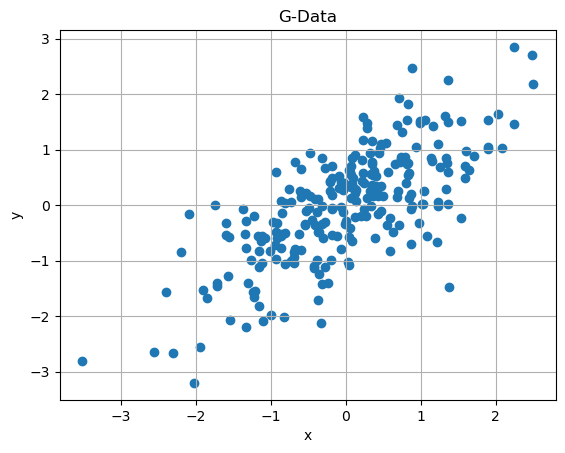

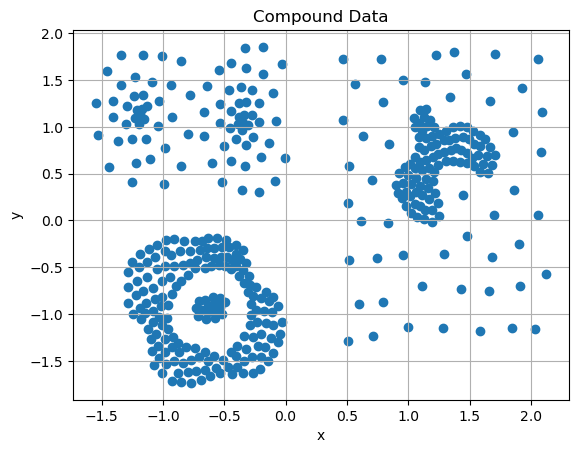

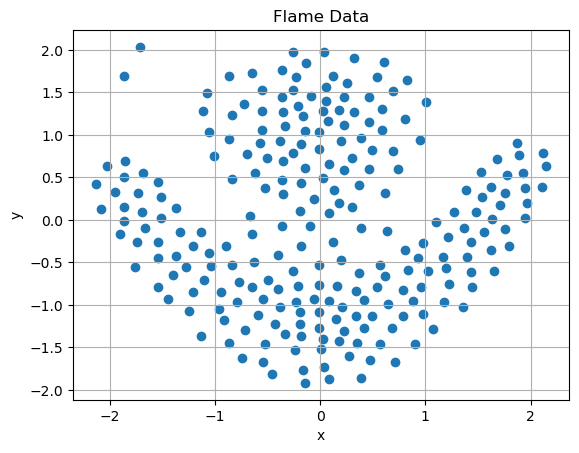

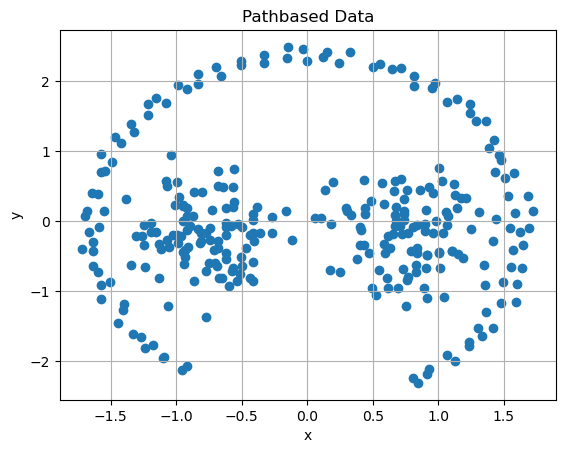

In [3]:
for k in datasets.keys():
    plt.scatter(datasets[k].x, datasets[k].y)
    plt.title(f"{k}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

## Part 1 (Using Parametric Models on G-Data):

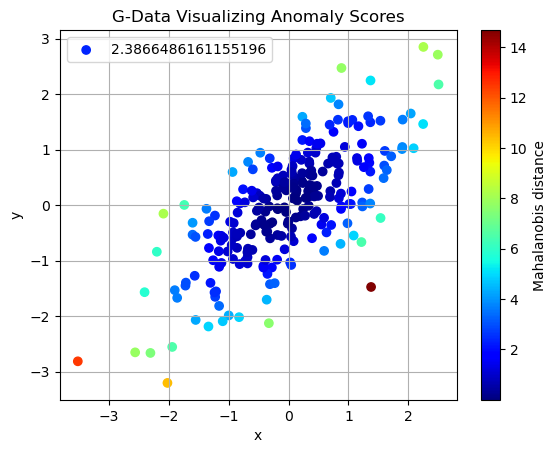

top five anomaly points:


,x,y,anomaly_score
41,1.376915,-1.474245,14.678287
8,-3.514537,-2.813186,12.453138
26,-2.019632,-3.202631,10.403718
67,-2.086532,-0.153715,8.193830
204,2.249512,2.849704,8.160705


In [4]:
# finding anomalies using Mahalanobis distance

g_data = pd.DataFrame(datasets['G-Data'])

g_cov_matrix = g_data.cov().values
g_column_means = g_data.mean(axis=0).values

# display(g_cov_matrix)
# display(g_column_means)


def mahalanobis(row):
    row = row.values
    return (row - g_column_means) @ np.linalg.inv(g_cov_matrix) @ (row - g_column_means)


g_data['anomaly_score'] = g_data.apply(mahalanobis, axis=1)


scatter = plt.scatter(g_data.x, g_data.y, c=g_data['anomaly_score'], cmap='jet')
colorbar = plt.colorbar(scatter)
colorbar.set_label('Mahalanobis distance')
plt.title("G-Data Visualizing Anomaly Scores")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(g_data['anomaly_score'])
plt.grid(True)
plt.show()

print(f'top five anomaly points:')
display(g_data.sort_values(by='anomaly_score', ascending=False).iloc[:5,:])


## Part 2 (Using Distance-Based Models):

In [5]:
from IPython.display import HTML

# Function to display DataFrames side by side
def display_side_by_side(*args):
    html_str = ''
    display(HTML('<table><tr>' + ''.join(f'<td>{df.to_html()}</td>' for df in args) + '</tr></table>'))

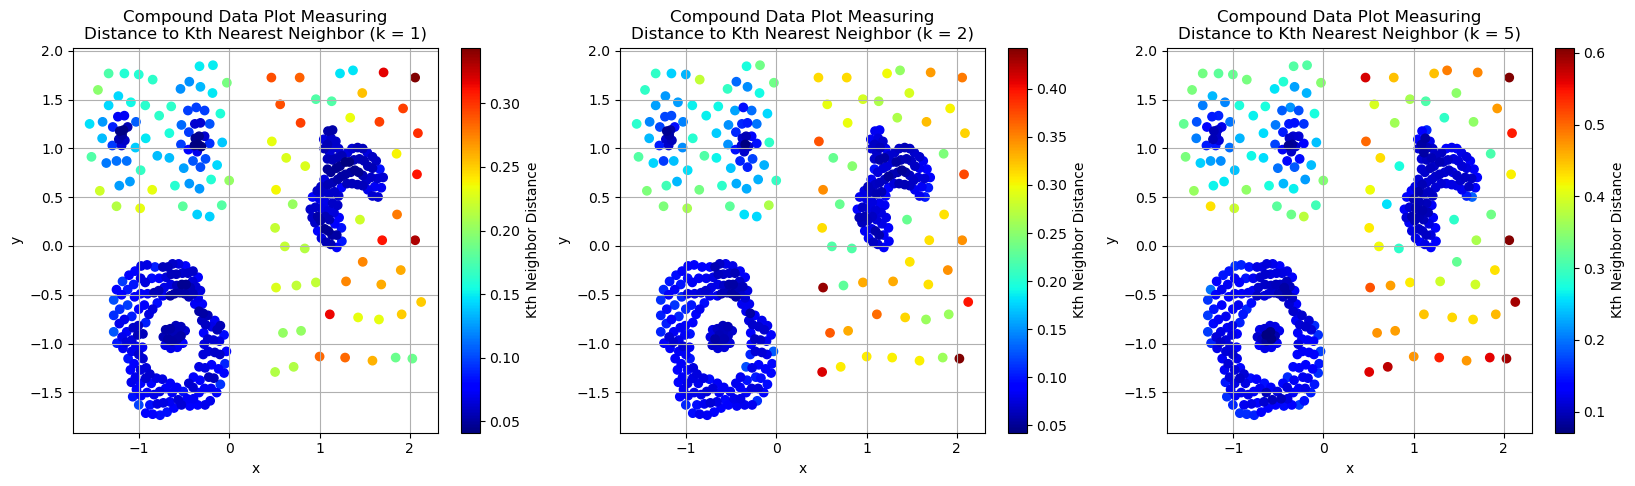

,x,y,distance_score
42,2.060247,1.726481,0.343683
28,2.060247,0.058959,0.331400
43,1.710616,1.779251,0.317007
16,1.114187,-0.700924,0.315234
26,1.695192,0.058959,0.309443
,x,y,distance_score
37,2.029397,-1.154744,0.442684
13,0.517758,-0.426522,0.433313
19,0.507475,-1.291945,0.410464
36,2.127088,-0.574277,0.397772


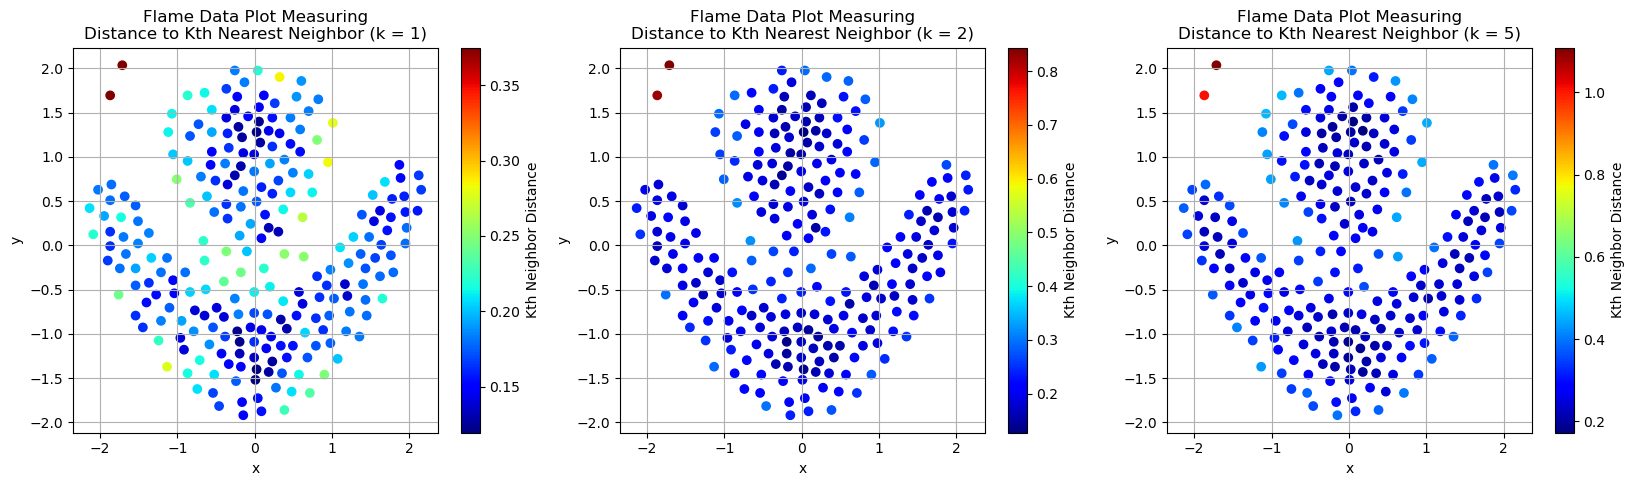

,x,y,distance_score
0,-1.712779,2.035183,0.374820
1,-1.869233,1.694577,0.374820
201,0.321122,1.901902,0.285100
192,0.946937,0.939320,0.283596
204,1.009519,1.383589,0.280054
,x,y,distance_score
0,-1.712779,2.035183,0.843624
1,-1.869233,1.694577,0.824410
204,1.009519,1.383589,0.326041
163,-0.664538,0.050782,0.320001


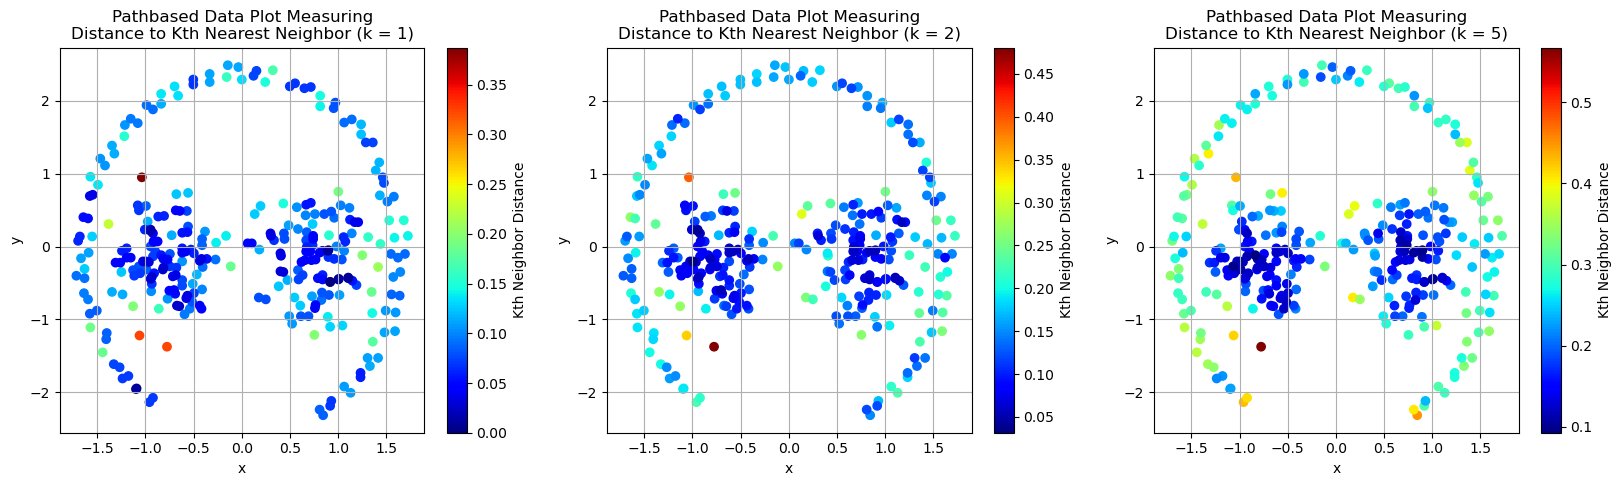

,x,y,distance_score
270,-1.037263,0.951303,0.387203
202,-0.776324,-1.374998,0.324108
203,-1.061537,-1.221052,0.324108
266,-1.383159,0.309860,0.225910
107,1.414351,-0.280268,0.208852
,x,y,distance_score
202,-0.776324,-1.374998,0.480553
270,-1.037263,0.951303,0.395705
203,-1.061537,-1.221052,0.341545
197,0.133929,0.446701,0.311672


In [6]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

knn = [2,3,6]

for d in datasets.keys():
    
    if(d == 'G-Data'):
        continue
    
    dataframes = []
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    
    for i,k in enumerate(knn):
        
        df = datasets[d].copy(deep=True)
        nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(df.values)
        distances, indices = nbrs.kneighbors(df.values)
        df['distance_score'] = distances[:,-1]
        df.sort_values(by='distance_score', ascending=False, inplace=True)
        dataframes.append(df)
        
        scatter = axes[i].scatter(x=df.x, y=df.y, c=df.distance_score, cmap='jet')
        axes[i].set_title(f"{d} Plot Measuring\nDistance to Kth Nearest Neighbor (k = {k-1})")
        colorbar = plt.colorbar(scatter, ax=axes[i])
        colorbar.set_label('Kth Neighbor Distance')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].grid(True)
                
    
    plt.show()
    display_side_by_side(dataframes[0].iloc[:5,:],dataframes[1].iloc[:5,:],dataframes[2].iloc[:5,:])

    
        
        
        
        

## Part 3: (Using Density-Based Models):

#### A. Density as the inverse of the distance to the kth nearest neigbor

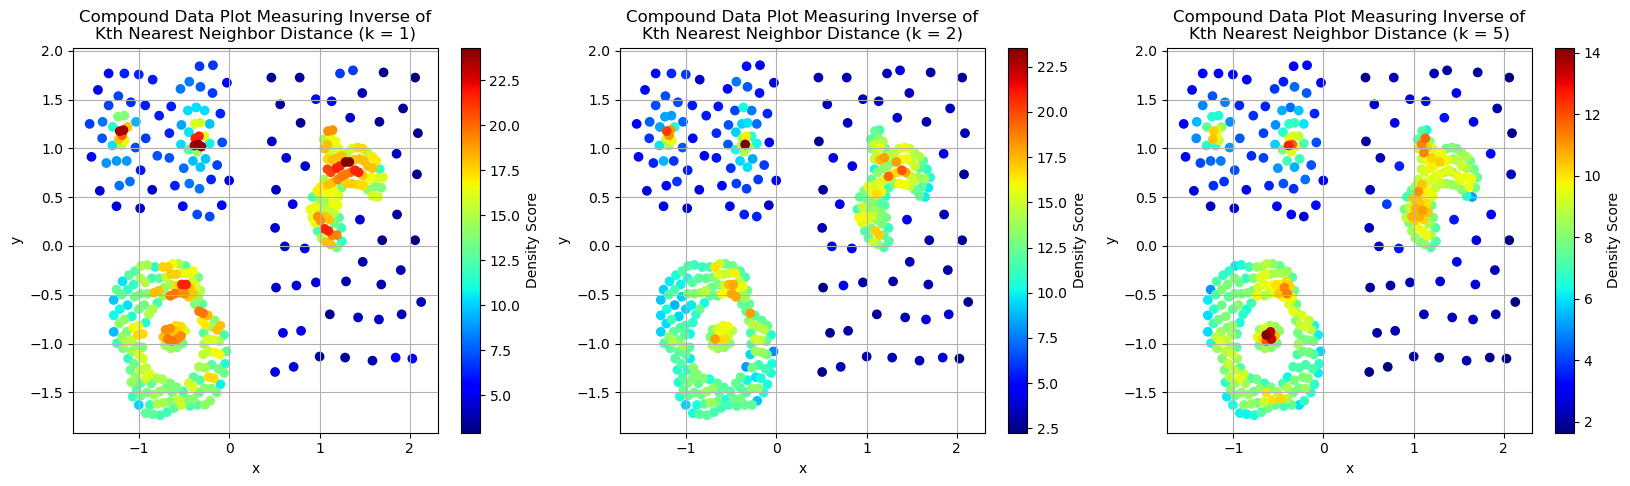

,x,y,density_score
42,2.060247,1.726481,2.909658
28,2.060247,0.058959,3.017505
43,1.710616,1.779251,3.154502
16,1.114187,-0.700924,3.172252
26,1.695192,0.058959,3.231616
,x,y,density_score
37,2.029397,-1.154744,2.258949
13,0.517758,-0.426522,2.307799
19,0.507475,-1.291945,2.436266
36,2.127088,-0.574277,2.514005


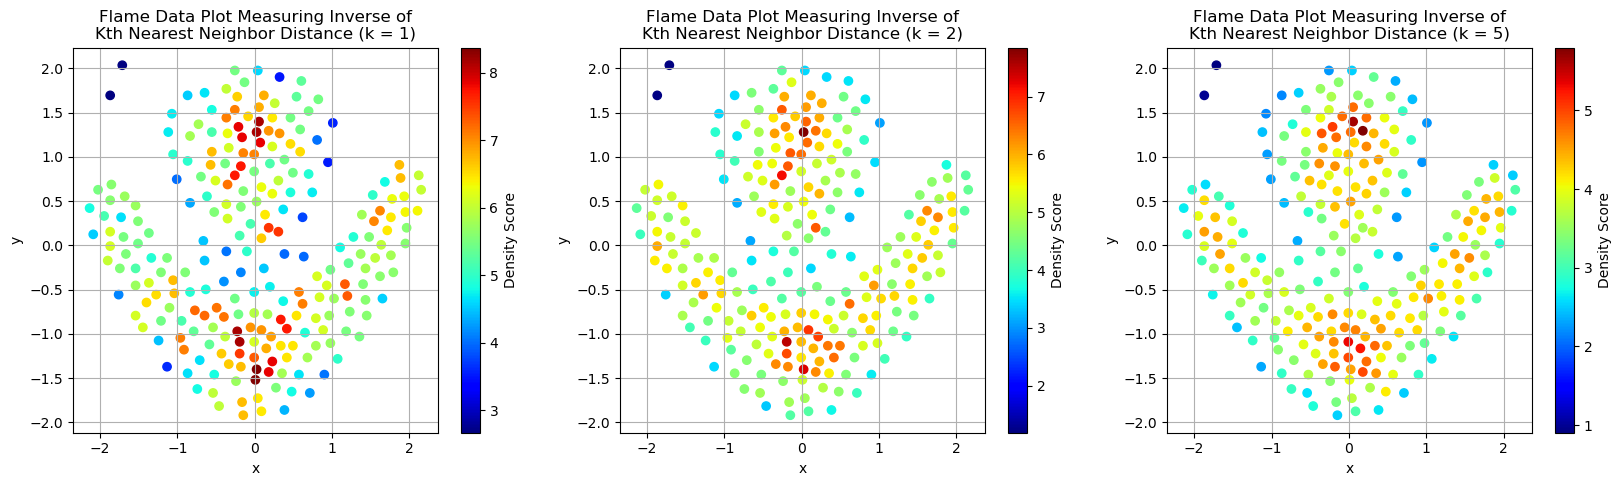

,x,y,density_score
0,-1.712779,2.035183,2.667945
1,-1.869233,1.694577,2.667945
201,0.321122,1.901902,3.507545
192,0.946937,0.939320,3.526138
204,1.009519,1.383589,3.570743
,x,y,density_score
0,-1.712779,2.035183,1.185363
1,-1.869233,1.694577,1.212989
204,1.009519,1.383589,3.067096
163,-0.664538,0.050782,3.124993


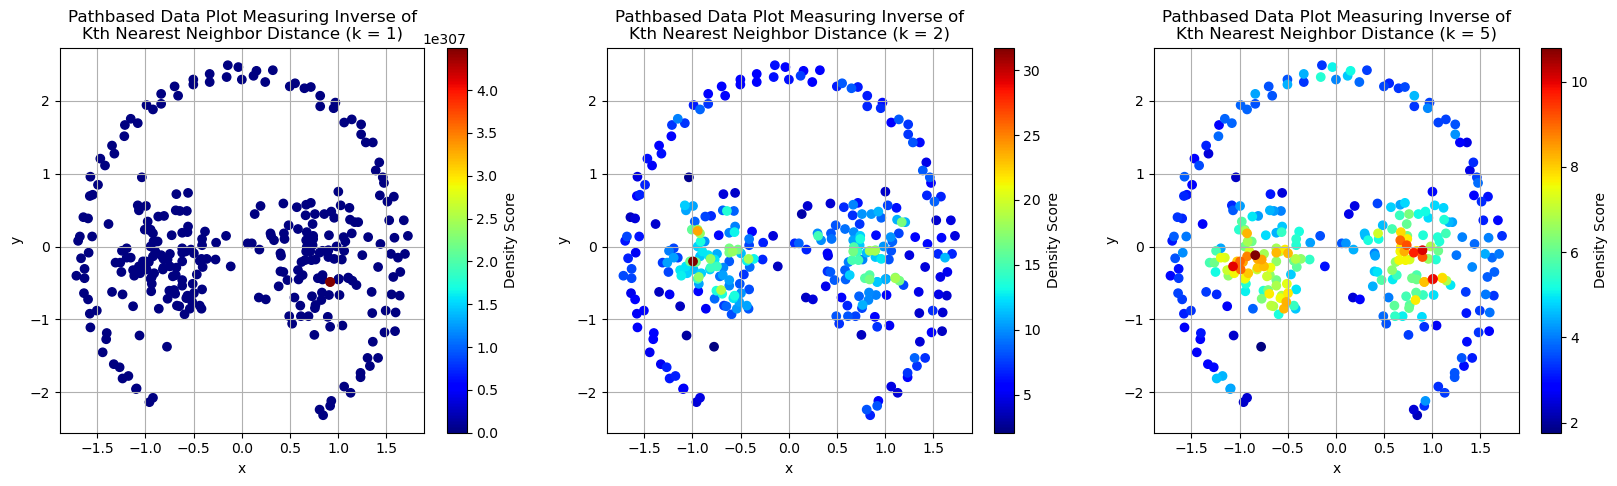

,x,y,density_score
270,-1.037263,0.951303,2.582623
203,-1.061537,-1.221052,3.085396
202,-0.776324,-1.374998,3.085396
266,-1.383159,0.309860,4.426540
107,1.414351,-0.280268,4.788080
,x,y,density_score
202,-0.776324,-1.374998,2.080937
270,-1.037263,0.951303,2.527133
203,-1.061537,-1.221052,2.927869
197,0.133929,0.446701,3.208504


In [7]:
import sys

knn = [2,3,6]

for d in datasets.keys():
    
    if(d == 'G-Data'):
        continue
    
    dataframes = []
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    
    for i,k in enumerate(knn):
        
        df = datasets[d].copy(deep=True)
        nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(df.values)
        distances, indices = nbrs.kneighbors(df.values)
        df['density_score'] = 1/(distances[:,-1]+sys.float_info.min)
        df.sort_values(by='density_score', ascending=True, inplace=True)
        dataframes.append(df)
        
        scatter = axes[i].scatter(x=df.x, y=df.y, c=df.density_score, cmap='jet')
        axes[i].set_title(f"{d} Plot Measuring Inverse of\nKth Nearest Neighbor Distance (k = {k-1})")
        colorbar = plt.colorbar(scatter, ax=axes[i])
        colorbar.set_label('Density Score')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].grid(True)
                
    
    plt.show()
    display_side_by_side(dataframes[0].iloc[:5,:],dataframes[1].iloc[:5,:],dataframes[2].iloc[:5,:])

#### A. Density as the inverse of the average distance to all k nearest neigbors

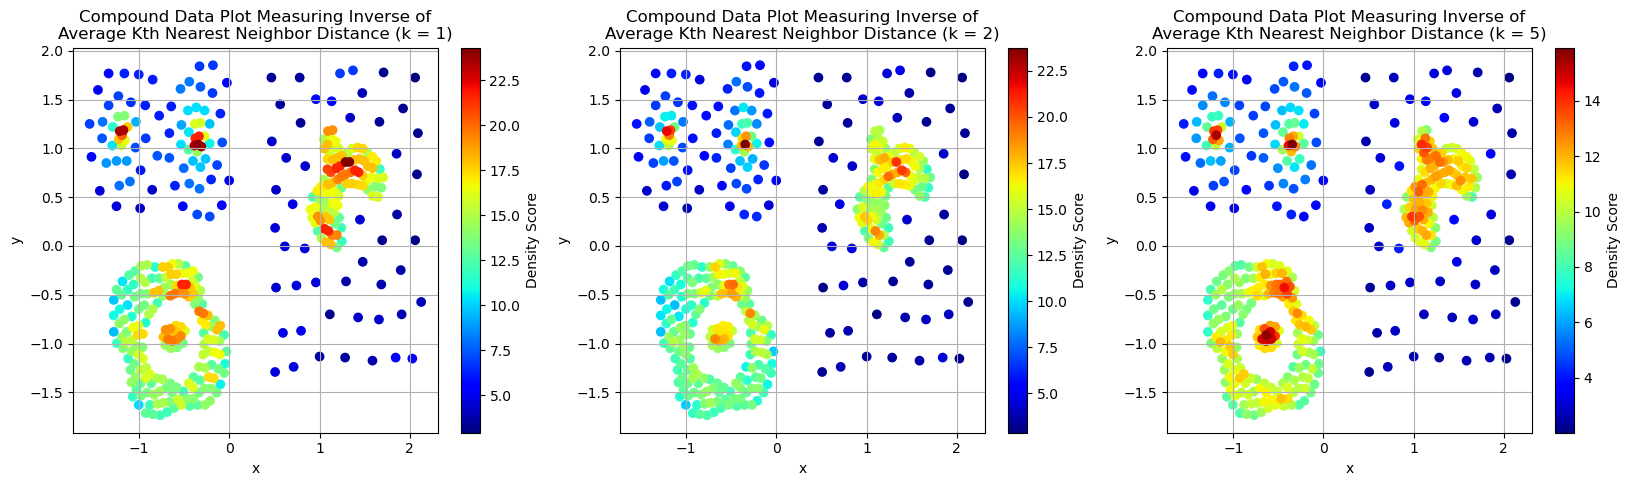

,x,y,density_score
42,2.060247,1.726481,2.909658
28,2.060247,0.058959,3.017505
43,1.710616,1.779251,3.154502
16,1.114187,-0.700924,3.172252
26,1.695192,0.058959,3.231616
,x,y,density_score
42,2.060247,1.726481,2.868314
38,2.080814,0.734411,2.915100
28,2.060247,0.058959,2.956480
16,1.114187,-0.700924,2.958679


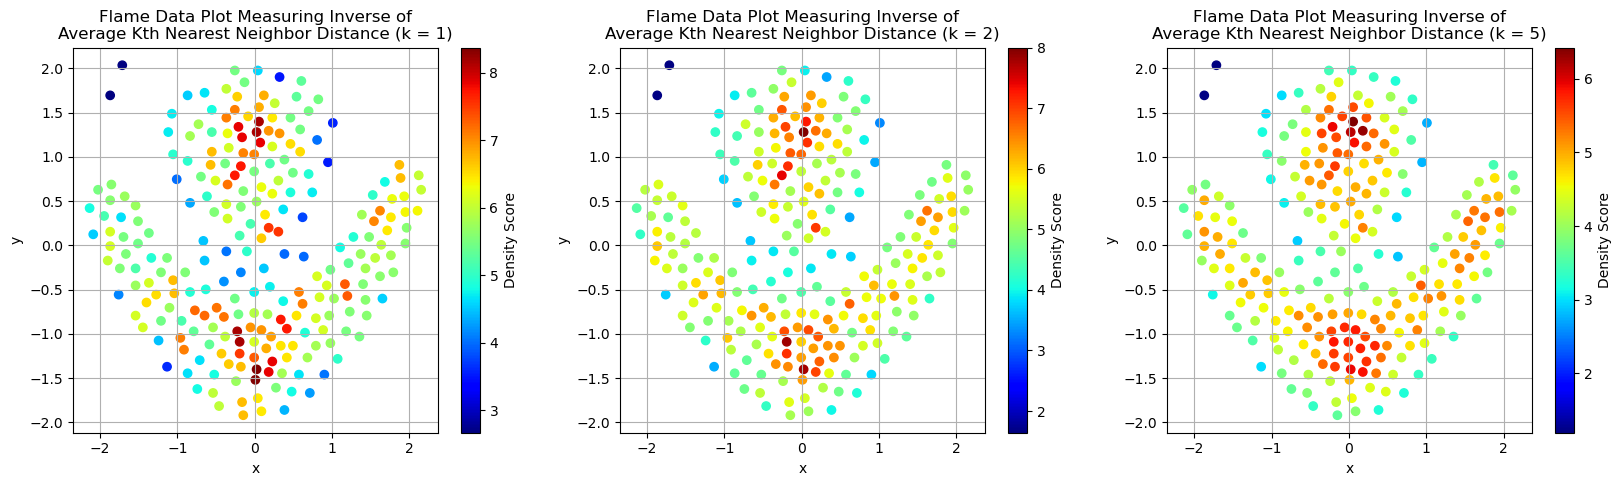

,x,y,density_score
0,-1.712779,2.035183,2.667945
1,-1.869233,1.694577,2.667945
201,0.321122,1.901902,3.507545
192,0.946937,0.939320,3.526138
204,1.009519,1.383589,3.570743
,x,y,density_score
0,-1.712779,2.035183,1.641438
1,-1.869233,1.694577,1.667736
204,1.009519,1.383589,3.299812
201,0.321122,1.901902,3.475041


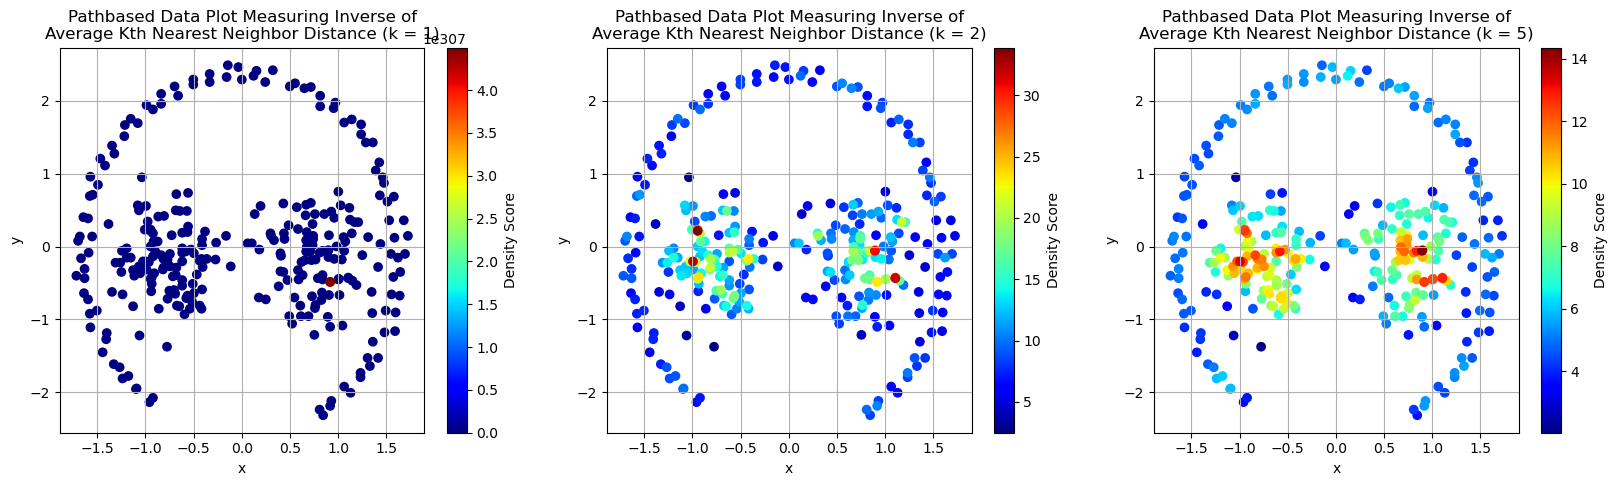

,x,y,density_score
270,-1.037263,0.951303,2.582623
203,-1.061537,-1.221052,3.085396
202,-0.776324,-1.374998,3.085396
266,-1.383159,0.309860,4.426540
107,1.414351,-0.280268,4.788080
,x,y,density_score
202,-0.776324,-1.374998,2.485521
270,-1.037263,0.951303,2.554577
203,-1.061537,-1.221052,3.004569
266,-1.383159,0.309860,4.282560


In [8]:
knn = [2,3,6]

for d in datasets.keys():
    
    if(d == 'G-Data'):
        continue
    
    dataframes = []
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    
    for i,k in enumerate(knn):
        
        df = datasets[d].copy(deep=True)
        nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(df.values)
        distances, indices = nbrs.kneighbors(df.values)
        df['density_score'] = 1/(distances[:,1:].mean(axis=1)+sys.float_info.min)
        df.sort_values(by='density_score', ascending=True, inplace=True)
        dataframes.append(df)
        
        scatter = axes[i].scatter(x=df.x, y=df.y, c=df.density_score, cmap='jet')
        axes[i].set_title(f"{d} Plot Measuring Inverse of\nAverage Kth Nearest Neighbor Distance (k = {k-1})")
        colorbar = plt.colorbar(scatter, ax=axes[i])
        colorbar.set_label('Density Score')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].grid(True)
                
    
    plt.show()
    display_side_by_side(dataframes[0].iloc[:5,:],dataframes[1].iloc[:5,:],dataframes[2].iloc[:5,:])